### Loading libraries

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import glob
import datetime
import random
from tqdm.notebook import tqdm
from PIL import Image
from PIL import ImageEnhance
pd.set_option('display.max_colwidth', None)

### Segmentation

Defining Paths

In [3]:
path = "./Images"
glob.glob(os.path.join(path,"*.JPG"))

['./Images/img0.JPG']

Visualizing Original Dataset

  0%|          | 0/1 [00:00<?, ?it/s]

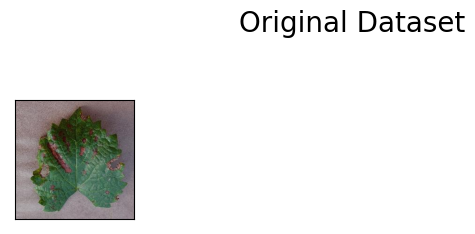

In [4]:
img_arr = []

for files in tqdm(glob.glob(os.path.join(path,"*.JPG"))):
  img = Image.open(files)
  img_arr.append(np.asarray(img))

num_images = len(img_arr)

plt.figure(figsize=(9,9))
for i, img in enumerate(img_arr[0:25]):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(img)
    plt.suptitle("Original Dataset", fontsize=20)
plt.show()

Grayscaling Images

In [5]:
gray = np.array([cv2.cvtColor(img,cv2.COLOR_RGB2GRAY) for img in tqdm(img_arr)])
gray.shape

  0%|          | 0/1 [00:00<?, ?it/s]

(1, 256, 256)

Visualizing Grayscaled Dataset

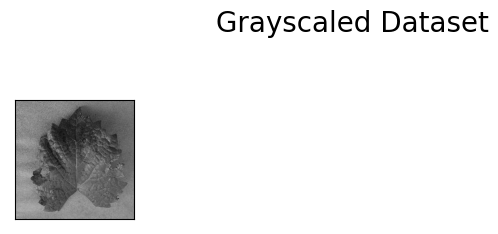

In [6]:
plt.figure(figsize=(9,9))
for i, img in enumerate(gray[0:25]):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_GRAY2RGB))
    plt.suptitle("Grayscaled Dataset", fontsize=20)
plt.show()

Thresholding (for improved contrast)

In [7]:
thresh = [cv2.threshold(img, np.mean(img), 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)[1] for img in tqdm(gray)]

  0%|          | 0/1 [00:00<?, ?it/s]

Visualizing Contrast Boosted Dataset

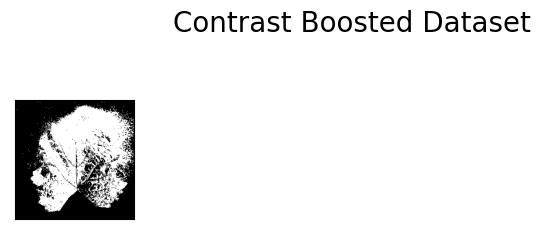

In [8]:
plt.figure(figsize=(9,9))
for i, img in enumerate(thresh[0:25]):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_GRAY2RGB))
    plt.suptitle("Contrast Boosted Dataset", fontsize=20)
plt.show()

Edge Detection and Segmenting mask

In [9]:
edges = [cv2.dilate(cv2.Canny(img, 0, 255), None) for img in tqdm(thresh)]
masked = []
segmented = []
for i, img in tqdm(enumerate(edges)):
    cnt = sorted(cv2.findContours(img, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)[-2], key=cv2.contourArea)[-1]
    mask = np.zeros((256,256), np.uint8)
    masked.append(cv2.drawContours(mask, [cnt],-1, 255, -1))
    dst = cv2.bitwise_and(img_arr[i], img_arr[i], mask=mask)
    segmented.append(cv2.cvtColor(dst, cv2.COLOR_BGR2RGB))

  0%|          | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Visualizing Segmented Masks

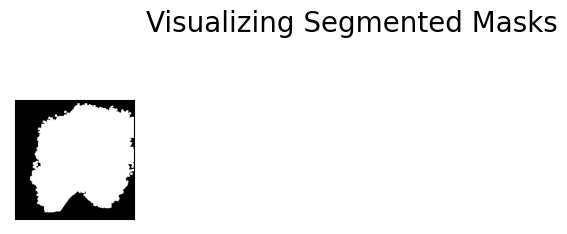

In [10]:
plt.figure(figsize=(9,9))
for i, segimg in enumerate(masked[0:25]):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(cv2.cvtColor(segimg, cv2.COLOR_BGR2RGB))
    plt.suptitle("Visualizing Segmented Masks", fontsize=20)
    cv2.imwrite('mask'+str(i)+'.jpg', segimg)
plt.show()

Visualizing Results

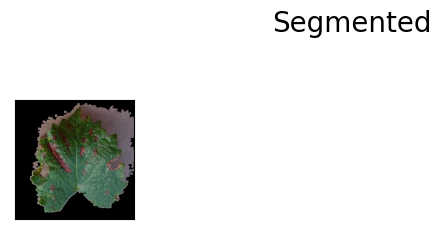

In [11]:
plt.figure(figsize=(9,9))
for i, segimg in enumerate(segmented[0:25]):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(cv2.cvtColor(segimg, cv2.COLOR_BGR2RGB))
    plt.suptitle("Segmented", fontsize=20)
plt.show()

### Finding Metrics

True Values for masks

In [12]:
img_masks = []
mask_path = './Masks/'
for files in tqdm(glob.glob(os.path.join(mask_path,"*.JPG"))):
  img = Image.open(files)
  img_masks.append(cv2.cvtColor(np.asarray(img),cv2.COLOR_RGB2GRAY))

  0%|          | 0/1 [00:00<?, ?it/s]

Interction Over Union

In [13]:
def print_IOU(seg_mask_img, org_mask_img):
    h,w = seg_mask_img.shape
    union = 0
    intersection = 0

    for i in range(0, h):
        for j in range(0,w):
            if org_mask_img[i][j]!=0 or seg_mask_img[i][j]!=0 :
                union+=1
            if org_mask_img[i][j]!=0 and seg_mask_img[i][j]!=0:
                intersection += 1
    
    iou = intersection/union

    print("IOU for image is ", iou)


In [14]:
for i in range(0, num_images):
    seg_mask_img = masked[i]
    org_mask_img = img_masks[i]

    print_IOU(seg_mask_img, org_mask_img)


IOU for image is  0.7786103542234333


Pixel Accuracy

In [17]:
def print_pixel_accuracy(seg_mask_img, org_mask_img):
    h,w = seg_mask_img.shape
    correct_pixel = 0
    total_pixel = h*w

    for i in range(0, h):
        for j in range(0,w):
            if org_mask_img[i][j]!=0 and seg_mask_img[i][j]!=0:
                correct_pixel += 1
            if org_mask_img[i][j]==0 and seg_mask_img[i][j]==0:
                correct_pixel += 1
    
    accuracy = correct_pixel / total_pixel

    print("Pixel Accuracy for image  is ", accuracy)

In [18]:
for i in range(0, num_images):
    seg_mask_img = masked[i]
    org_mask_img = img_masks[i]

    print_pixel_accuracy(seg_mask_img, org_mask_img)


Pixel Accuracy for image  is  0.86114501953125


F1 Score

In [19]:
def print_f1_score(seg_mask_img, org_mask_img):
    h,w = seg_mask_img.shape
    overlap = 0

    pixel_1 = 0
    pixel_2 = 0

    for i in range(0, h):
        for j in range(0,w):
            if org_mask_img[i][j]!=0 and seg_mask_img[i][j]!=0 :
                overlap+=1
            if org_mask_img[i][j]!=0 :
                pixel_1 += 1
            if seg_mask_img[i][j]!=0:
                pixel_2 += 1
    
    f1 = 2*(overlap)/(pixel_2 + pixel_1)

    print("F1 score for image is ", f1)

In [20]:
for i in range(0, num_images):
    seg_mask_img = masked[i]
    org_mask_img = img_masks[i]

    print_f1_score(seg_mask_img, org_mask_img)


F1 score for image is  0.875526618153964
